Notebook to generate data file that is a subset of the SGA catalog with rotational velocities measured during Y3 (jura).

In [1]:
import numpy as np

from astropy.table import Table, join
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const

from tqdm import tqdm

from corner import corner

import matplotlib.pyplot as plt

In [2]:
c = const.c.to('km/s')

q0 = 0.2

# Redrock systematic duplicate redshift uncertainty (from Lan+23)
dv_sys = 7 # km/s
dz_sys = dv_sys/c.value
#### ultimately dz = (1+z) dv/c, but we will multiply this by (1+z) for each observation

# Data

## jura

In [5]:
tjura = Table.read('desi_pv_tf_jura_healpix.fits')
# tjura = Table.read('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_jura_healpix.fits')
# tjura = Table.read('/Users/kdouglass/Documents/Research/data/DESI/Y1/desi_pv_tf_jura_healpix.fits')
tjura[:5]

TARGETID,TARGET_RA,TARGET_DEC,MEAN_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_RA,STD_FIBER_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,PVTYPE,SGA_ID,PHOTSYS,SKY_FIBER_DIST,SKY_FIBER_DIST_R26
int64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,float64,int64,bytes3,int32,bytes1,float64,float64
-430502046,134.00013295228783,5.934552839997555,134.0000012447711,5.934402495943119,0.0,0.0,1.5211813094599733,9.536633276548175e-05,GALAXY,21.043927863240242,2049,TFT,838970,S,0.0,0.0
-427872363,61.981718642816155,-22.823913110732356,61.981815755036905,-22.824112647850505,0.01692960597574711,0.01899055577814579,0.049085960824979194,8.765385426009584e-06,GALAXY,320.327581204474,2049,TFT,982213,S,0.0,0.0
-411444222,156.2181500220905,7.1584828480845655,156.21807676457115,7.1586258676041306,0.0,0.0,0.7655265334224575,0.00014819907104570706,GALAXY,2.862433671951294,2053,TFT,4614,S,0.0,0.0
-261707523,51.18809619857989,-15.380001206793725,51.18805131712048,-15.379972719695512,0.18443052470684052,0.270201712846756,0.11706841864860068,1.263477560383397e-05,GALAXY,5022.345633155666,512,SGA,788458,S,0.0,0.0
-260779407,138.32747528464944,17.5639019859795,138.32760054746495,17.56391743552376,0.0,0.0,0.08569271543378945,9.438671035622181e-06,GALAXY,243.51359286904335,2560,TFT,735997,S,0.0,0.0


### Update all Redrock uncertainties to account for 7 km/s statistical uncertainty

In [6]:
tjura['ZERR_MOD'] = np.sqrt(tjura['ZERR']**2 + (dz_sys*(1 + tjura['Z']))**2)

### Are $\sigma_z$ small relative to $z$?

In [7]:
np.max(tjura['ZERR_MOD']/tjura['Z'])

508.80968562719727

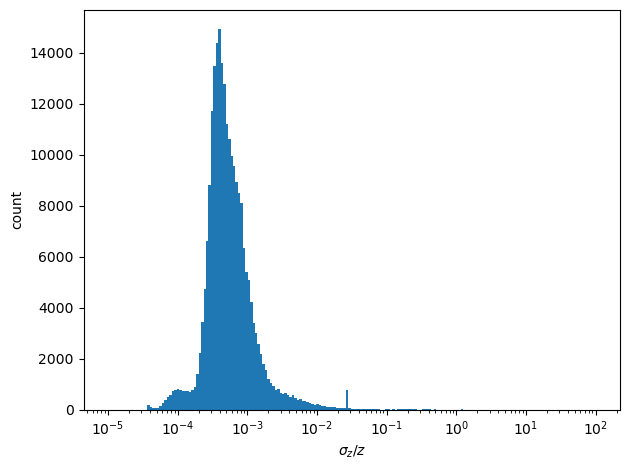

In [8]:
plt.figure(tight_layout=True)

plt.hist(tjura['ZERR_MOD']/tjura['Z'], bins=np.logspace(-5, 2, 200))

plt.xscale('log')

plt.xlabel(r'$\sigma_z/z$')
plt.ylabel('count');

## SGA

In [9]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
# SGA = Table.read('/Users/kdouglass/Documents/Research/data/SGA/SGA-2020.fits', 'ELLIPSE')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [10]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

# Separate the jura data into center and off-center observations

In [14]:
tjura['SKY_FIBER_DIST'] = 0.
tjura['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in tqdm(np.unique(tjura['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tjura['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tjura['TARGET_RA'][obs_idx], 
                             dec=tjura['TARGET_DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tjura['SKY_FIBER_DIST'][obs_idx] = sep2d
    tjura['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

100%|██████████| 146579/146579 [09:15<00:00, 263.93it/s]


In [15]:
centers_boolean = tjura['SKY_FIBER_DIST_R26'] < 0.1

jura_centers = tjura[centers_boolean]
jura_axis = tjura[~centers_boolean]

## Clean the jura center observations

Only keep those with
* `DELTACHI2` > 25
* `ZWARN` == 0
* passed VI

In [16]:
good_centers = jura_centers[(jura_centers['DELTACHI2'] > 25) & (jura_centers['ZWARN'] == 0)]
print(len(np.unique(good_centers['SGA_ID'])), len(good_centers))

138013 152853


In [17]:
jura_VI = Table.read('jura_VI.txt', format='ascii.commented_header')

centers_VI = np.ones(len(good_centers), dtype=bool)

for targetid in jura_VI['TARGETID']:
    
    if targetid in good_centers['TARGETID']:
        centers_VI = centers_VI & (good_centers['TARGETID'] != targetid)
        
good_centers_VI = good_centers[centers_VI]
print(len(np.unique(good_centers_VI['SGA_ID'])), len(good_centers_VI))

137948 152785


### How does $\sigma_z$ compare with $z$ for the good center observations?

In [18]:
print(np.max(good_centers['ZERR_MOD']/good_centers['Z']), np.max(jura_axis['ZERR_MOD']/jura_axis['Z']))

508.80968562719727 21.09247603356103


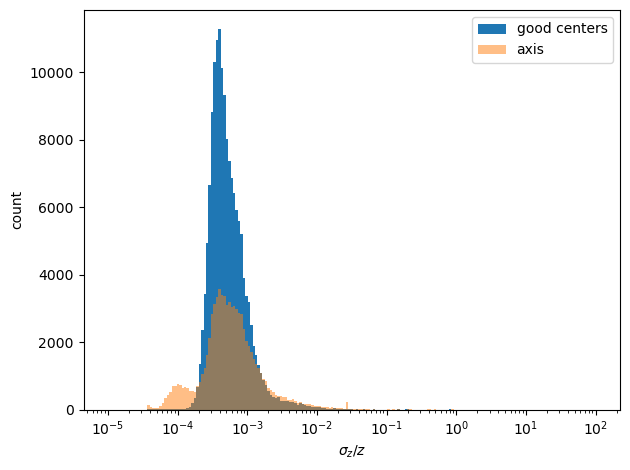

In [19]:
plt.figure(tight_layout=True)

plt.hist(good_centers['ZERR_MOD']/good_centers['Z'], bins=np.logspace(-5, 2, 200), label='good centers')
plt.hist(jura_axis['ZERR_MOD']/jura_axis['Z'], bins=np.logspace(-5, 2, 200), alpha=0.5, label='axis')

plt.xscale('log')

plt.legend()

plt.xlabel(r'$\sigma_z/z$')
plt.ylabel('count');

## If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [22]:
rng = np.random.default_rng()

N_samples = 10000 # for large error propagation

In [ ]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan
SGA['PHOTSYS'] = ''

# weights = 1./(good_centers_VI['ZERR']**2)
weights = 1./(good_centers_VI['ZERR_MOD']**2)

for sga_id in tqdm(np.unique(good_centers_VI['SGA_ID'])):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers_VI['SGA_ID'] == sga_id
    N_obs = np.sum(obs_idx)
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers_VI['Z'][obs_idx], 
                                        weights=weights[obs_idx])

    # Compute the uncertainty in the center redshift
    # if (N_obs == 1) or np.all(np.abs(good_centers_VI['ZERR_MOD'][obs_idx]/good_centers_VI['Z'][obs_idx]) < 0.05):
    #     SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1/np.sum(weights[obs_idx]))
    # else:
    z_random = np.zeros((N_obs, N_samples))

    for i in range(N_obs):
        z_random[i] = rng.normal(loc=good_centers_VI['Z'][obs_idx][i], 
                                 scale=good_centers_VI['ZERR_MOD'][obs_idx][i], 
                                 size=N_samples)

    avg_z_random = np.average(z_random, 
                              weights=weights[obs_idx,None]*np.ones(N_samples), 
                              axis=0)
    SGA['ZERR_DESI'][SGA_idx] = np.std(avg_z_random)

    
    ## also store the PHOTSYS value since we will need this later
    SGA['PHOTSYS'][SGA_idx] = good_centers_VI['PHOTSYS'][obs_idx][0]

 86%|████████▌ | 118940/137948 [02:10<00:19, 989.60it/s] 

In [ ]:
plt.figure(tight_layout=True)

plt.hist(SGA['ZERR_DESI']/SGA['Z_DESI'], bins=np.logspace(-5, 2, 200))

plt.xscale('log')

plt.xlabel(r'$\sigma_z/z$')
plt.ylabel('count');

# Calculate the rotational velocities

In [ ]:
jura_axis['V_ROT'] = np.nan
jura_axis['V_ROT_ERR'] = np.nan

# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in tqdm(np.unique(good_centers_VI['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = jura_axis['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = SGA['Z_DESI'][sga_idx]
    z_err_center = SGA['ZERR_DESI'][sga_idx]

    # Calculate rotational velocity for all observations of the galaxy
    # jura_axis['V_ROT'][obs_idx] = c*(jura_axis['Z'][obs_idx] - z_center)
    z_rot = (1 + jura_axis['Z'][obs_idx])/(1 + z_center) - 1
    jura_axis['V_ROT'][obs_idx] = c*z_rot
    # if sga_gal == 55:
    #     print(z_rot)
    #     print(jura_axis['V_ROT'][obs_idx])
    
    # Calculate uncertainty in the rotational velocity
    # if np.all(np.abs(jura_axis['ZERR_MOD'][obs_idx]/jura_axis['Z'][obs_idx]) < 0.05) and (z_err_center/z_center < 0.05):
    #     # jura_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt(jura_axis['ZERR'][obs_idx]**2 + z_err_center**2)
    #     # jura_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt((jura_axis['ZERR'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + iron_axis['Z'][obs_idx])/(1 + z_center)**2) + (dv_sys/c).value**2)
    #     jura_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt((jura_axis['ZERR_MOD'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + iron_axis['Z'][obs_idx])/(1 + z_center)**2))
    # else:
    z_center_random = rng.normal(loc=z_center, 
                                 scale=z_err_center,
                                 size=N_samples)

    z_axis_random = np.zeros((np.sum(obs_idx), N_samples))

    for i in range(np.sum(obs_idx)):
        z_axis_random[i] = rng.normal(loc=jura_axis['Z'][obs_idx][i], 
                                      scale=jura_axis['ZERR_MOD'][obs_idx][i], 
                                      size=N_samples)

    z_rot_random = (1 + z_axis_random)/(1 + z_center_random) - 1

    jura_axis['V_ROT_ERR'][obs_idx] = np.std(np.abs(c*z_rot_random), axis=1)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    jura_axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    jura_axis['V_ROT_ERR'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------
    # if sga_gal == 55:
    #     print(jura_axis['V_ROT'][obs_idx])

In [ ]:
plt.figure(tight_layout=True)

plt.hist(np.abs(jura_axis['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V(0.4R_{26})$ [km/s]')
plt.ylabel('number of observations');

# Quality criteria for velocities

Requirements:
* $10 < V_{rot} < 1000$ km/s at $0.4R_{26}$
* $\Delta V / V_{min} \leq 5$
* passes VI

## Velocity cut

In [ ]:
r0p4 = (jura_axis['SKY_FIBER_DIST_R26'] > 0.38) & (jura_axis['SKY_FIBER_DIST_R26'] < 0.42)

Vgood = (np.abs(jura_axis['V_ROT']) < 1000) & (np.abs(jura_axis['V_ROT']) > 10)

good_axis = jura_axis[r0p4 & Vgood]

print(len(good_axis), len(np.unique(good_axis['SGA_ID'])))

## Visual inspection

Cutouts for this were generated with the `TF_Y1_VI.ipynb` notebook.

In [ ]:
axis_VI = np.ones(len(good_axis), dtype=bool)

for targetid in jura_VI['TARGETID']:
    
    if targetid in good_axis['TARGETID']:
        axis_VI = axis_VI & (good_axis['TARGETID'] != targetid)
        
good_axis_VI = good_axis[axis_VI]
print(len(good_axis_VI), len(np.unique(good_axis_VI['SGA_ID'])))

## Relative velocity cut

In [ ]:
good_deltaV = np.ones(len(good_axis_VI), dtype=bool)

deltachi2_idx = good_axis_VI['DELTACHI2'] >= 25

for sga_id in tqdm(np.unique(good_axis_VI['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_VI['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_VI['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_VI['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_VI['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_VI['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_VI['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_VI['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin

        # if sga_id == 655903:
        #     print(diff_matrix_norm)
        #     break
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_VI['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_VI['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_VI['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False

In [ ]:
good_deltaV_axis_VI = good_axis_VI[good_deltaV]

print(len(good_deltaV_axis_VI), len(np.unique(good_deltaV_axis_VI['SGA_ID'])))

## Same side check

Confirm that all velocities measured on the same side of the galaxy have the same sign (either positive or negative), and that velocities measured on opposite sides have the opposite sign.  If one of these cases fails, remove observations with `DELTACHI2` < 25 and recheck.  If it still fails, remove all observations on that side of the galaxy, or that galaxy.

In [ ]:
def check_sides(galaxies):
    '''
    Check that the rotational velocities have the same sign on each side of the 
    galaxy.
    '''
    # Find which observations are on the same, opposite side
    same_side = (galaxies['TARGET_RA'] == galaxies['TARGET_RA'][0]) & (galaxies['TARGET_DEC'] == galaxies['TARGET_DEC'][0])

    # Check that all velocities on the same side as the first in the table have 
    # the same sign
    same1 = galaxies['V_ROT'][same_side] > 0
    check_same = np.all(same1 == same1[0])

    # Check if there are observations on the opposite side of the galaxy from 
    # the first one in the table
    if np.sum(same_side) < len(galaxies):

        # Check that all the velocities on this size have the same sign
        same2 = galaxies['V_ROT'][~same_side] > 0
        check_same2 = np.all(same2 == same2[0])

        # Check that the signs are opposite each other on the two sides
        check_opposite = check_same & check_same2 & (same1[0] != same2[0])

        # Combine all the checks into one boolean value
        check_same = check_same & check_same2 & check_opposite

    return check_same

In [ ]:
same_side_good = np.ones(len(good_deltaV_axis_VI), dtype=bool)

deltachi2_idx = good_deltaV_axis_VI['DELTACHI2'] >= 25


for sga_id in tqdm(np.unique(good_deltaV_axis_VI['SGA_ID'])):

    # Identify all galaxy targets on this galaxy
    obs_idx = good_deltaV_axis_VI['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:

        # Make a small table of just this galaxy
        this_gal = good_deltaV_axis_VI[obs_idx]

        deltachi2_this_gal = this_gal['DELTACHI2'] >= 25

        # Check the observations
        check_same = check_sides(this_gal)

        if ~check_same:
            # At least one of the observations is the wrong sign

            # First, just remove all with DELTACHI2 < 25 from the sample
            same_side_good[obs_idx & ~deltachi2_idx] = False

            # Which observations are left?
            good_obs_idx = obs_idx & deltachi2_idx

            # How many observations are left?
            n_obs_good = np.sum(good_obs_idx)

            if n_obs_good > 1:

                # Recheck those that are left to see if they pass
                check_same_again = check_sides(good_deltaV_axis_VI[good_obs_idx])

                # If this still fails, remove all observations on this side
                if ~check_same_again:
                    same_side_good[obs_idx] = False

In [ ]:
good_deltaV_axis_VI_same = good_deltaV_axis_VI[same_side_good]

print(len(good_deltaV_axis_VI_same), len(np.unique(good_deltaV_axis_VI_same['SGA_ID'])))

# Compute the weighted average velocity for those galaxies with more than one observation at $0.4R_{26}$

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$

In [ ]:
# np.set_printoptions(precision=20)

SGA['V_0p4R26'] = np.nan
SGA['V_0p4R26_ERR'] = np.nan

weights = 1./(good_deltaV_axis_VI_same['V_ROT_ERR']**2)

# contour_colors = iter(plt.cm.viridis(np.linspace(0,1,2600)))
# fig, ax = plt.subplots(tight_layout=True)

for sga_id in tqdm(np.unique(good_deltaV_axis_VI_same['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_deltaV_axis_VI_same['SGA_ID'] == sga_id
    N_obs = np.sum(obs_idx)
    
    #---------------------------------------------------------------------------
    # Combine all redshifts that are measured in the same spot (i.e., on the 
    # same side of the galaxy)
    #---------------------------------------------------------------------------
    if N_obs > 1:
        # print('There is more than one observation on this galaxy')
        
        # axis_z_list = []
        # axis_z_err_list = []
        
        # Make a small table of just this galaxy
        this_gal = good_deltaV_axis_VI_same[obs_idx]

        weights_z = 1./(this_gal['ZERR_MOD']**2)
        
        # Observations that are on the same side as the first one in this list
        same_side = (this_gal['TARGET_RA'] == this_gal['TARGET_RA'][0]) & (this_gal['TARGET_DEC'] == this_gal['TARGET_DEC'][0])

        # if sga_id == 655903:
        #     print(same_side)
        #     break

        # Do we have observations on one or both sides of the galaxy?
        sides = np.unique(same_side)
        N_sides = len(sides)

        axis_z_list = np.zeros(N_sides, dtype=np.float64)
        axis_z_err_list = np.zeros(N_sides, dtype=np.float64)
        
        # Compute the weighted average redshift of all observations on the same 
        # side of the galaxy as the first one in the list
        avg_z_same = np.average(this_gal['Z'][same_side], 
                                weights=weights_z[same_side])
        avg_z_err_same = np.sqrt(1./np.sum(weights_z[same_side]))

        # print(avg_z_same)
        axis_z_list[0] = avg_z_same
        # print(axis_z_list)
        axis_z_err_list[0] = avg_z_err_same

        # If there are any observations on the other side from the first 
        # observation, compute their weighted average
        if N_sides == 2:
            
            avg_z_opp = np.average(this_gal['Z'][~same_side], 
                                   weights=weights_z[~same_side])
            avg_z_err_opp = np.sqrt(1./np.sum(weights_z[~same_side]))

            axis_z_list[1] = avg_z_opp
            axis_z_err_list[1] = avg_z_err_opp

        # Grab the center redshift and uncertainty for this galaxy
        z_center = SGA['Z_DESI'][SGA_dict[sga_id]]
        z_err_center = SGA['ZERR_DESI'][SGA_dict[sga_id]]
        
        # Compute the rotational velocity of these average redshifts on either 
        # side
        axis_z_rot = (1 + axis_z_list)/(1 + z_center) - 1
        axis_V = np.abs(c.value*axis_z_rot)

        if sga_id == 655903:
            print(axis_V)
            break

        
        # if (N_sides > 1) or ((N_sides == 1) and ((z_err_center/z_center > 0.05) or (avg_z_err_same/avg_z_same > 0.05))):
            
        z_center_random = rng.normal(loc=z_center, 
                                     scale=z_err_center,
                                     size=N_samples)

        z_axis_random = np.zeros((N_sides, N_samples))

        for i in range(N_sides):
            z_axis_random[i] = rng.normal(loc=axis_z_list[i], 
                                          scale=axis_z_err_list[i], 
                                          size=N_samples)

        z_rot_random = (1 + z_axis_random)/(1 + z_center_random) - 1
        v_rot_random = c.value*np.abs(z_rot_random)

        axis_V_err = np.std(v_rot_random, axis=1)
        # print(axis_V_err.shape)

        if len(axis_V) > 1:

            # corner(c.value*np.abs(z_rot_random).T, 
            #        bins=25, 
            #        smooth=1, 
            #        truths=axis_V,
            #        fill_contours=True, 
            #        show_titles=True)

            # counts, xedges, yedges = np.histogram2d(np.abs(c.value*z_rot_random[0]) - axis_V[0], 
            #                                         np.abs(c.value*z_rot_random[1]) - axis_V[1], 
            #                                         bins=20)
            # color = next(contour_colors)
            # ax.contour(xedges[:-1], yedges[:-1], counts, colors='k', alpha=0.1)
            # break

            # Calculate correlation coefficient between the two velocities
            # corr_coeff = np.corrcoef(np.abs(z_rot_random))[0,1]
            # print(corr_coeff)
            # print(sga_id)
            # break
            
            # Calculate weighted average of the two velocities
            axis_V = np.average(axis_V, weights=1./axis_V_err**2)

            # Calculate uncertainty of the average velocity
            # axis_V_err = np.sqrt(np.sum(axis_V_err**2) + corr_coeff*axis_V_err[0]*axis_V_err[1])
            axis_v_random = np.average(v_rot_random, 
                                       weights=1./(np.ones(N_samples)*axis_V_err[:,None]**2), 
                                       axis=0)
            axis_V_err = np.std(axis_v_random)
            # print(axis_v_random.shape)
            # break
                

        # else:
        #     # There is only one average velocity that we need to worry about, 
        #     # and both it and the center redshift have relatively small uncertainties 
        #     axis_V_err = c.value*np.sqrt((avg_z_err_same/(1 + z_center))**2 + z_err_center**2*((1 + avg_z_same)/(1 + z_center)**2))

        #----------------------------------------------------------------------
        # Correct for inclination
        #----------------------------------------------------------------------
        cosi2 = (SGA['BA'][SGA_dict[sga_id]]**2 - q0**2)/(1 - q0**2)
    
        # Galaxies with b/a < q0
        if cosi2 < 0:
            cosi2 = 0
        
        axis_V /= np.sin(np.arccos(np.sqrt(cosi2)))
        axis_V_err /= np.sin(np.arccos(np.sqrt(cosi2)))
        #----------------------------------------------------------------------
        
    else:
        axis_V = np.abs(good_deltaV_axis_VI_same['V_ROT'][obs_idx])
        axis_V_err = good_deltaV_axis_VI_same['V_ROT_ERR'][obs_idx]
    #---------------------------------------------------------------------------

    SGA['V_0p4R26'][SGA_dict[sga_id]] = axis_V
    SGA['V_0p4R26_ERR'][SGA_dict[sga_id]] = axis_V_err
    '''
    SGA['V_0p4R26'][SGA_dict[sga_id]] = np.average(np.abs(good_deltaV_axis_VI['V_ROT'][obs_idx]), 
                                                   weights=weights[obs_idx])
    
    if (N_obs == 1) or np.all(np.abs(good_deltaV_axis_VI['V_ROT_ERR'][obs_idx]/good_deltaV_axis_VI['V_ROT'][obs_idx]) < 0.05):
        SGA['V_0p4R26_ERR'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))
    else:
        v_random = np.zeros((N_obs, N_samples))

        for i in range(N_obs):
            v_random[i] = rng.normal(loc=np.abs(good_deltaV_axis_VI['V_ROT'][obs_idx][i]), 
                                     scale=good_deltaV_axis_VI['V_ROT_ERR'][obs_idx][i], 
                                     size=N_samples)

        v_avg_random = np.average(v_random, 
                                  weights=weights[obs_idx,None]*np.ones(N_samples),
                                  axis=0)
        SGA['V_0p4R26_ERR'][SGA_dict[sga_id]] = np.std(v_avg_random)
    ''';

In [ ]:
# Make a catalog of just those galaxies with velocities
SGA_TF_jura = SGA[np.isfinite(SGA['V_0p4R26']) & (SGA['R_MAG_SB26'] > 0)]

In [ ]:
plt.figure(tight_layout=True)

plt.plot(SGA_TF_jura['V_0p4R26_ERR'], SGA_TF_jura['V_0p4R26'], '.', alpha=0.1)

plt.xlim(0,50)
plt.ylim(-5, 400)

plt.xlabel('$\sigma_V$ [km/s]')
plt.ylabel('$V(0.4R_{26})$ [km/s]');

In [ ]:
plt.figure(tight_layout=True)

plt.hist(SGA_TF_jura['V_0p4R26'], bins=np.linspace(-1, 500, 100))

plt.xlabel('$V(0.4R_{26})$ [km/s]');

In [ ]:
plt.figure(tight_layout=True)

plt.plot(SGA_TF_jura['Z_DESI'], SGA_TF_jura['V_0p4R26'], '.', alpha=0.1)

plt.xlim(0, 0.15)
plt.ylim(-5, 400)

plt.xlabel('$z_{DESI}$')
plt.ylabel('$V(0.4R_{26})$ [km/s]');

In [ ]:
SGA_TF_jura[:5]

# Write final catalog to file

In [35]:
# SGA_TF_jura.write('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_jura_Vrot.fits')
# SGA_TF_jura_photsys.write('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_jura_Vrot_dVsys_VI_photsys.fits', 
SGA_TF_jura.write('vrot_cats/SGA-2020_jura_Vrot_v1.fits',
                          overwrite=True)

In [36]:
#SGA_TF_jura.write('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y3/SGA-2020_jura_Vrot_v1.fits'

# Compare the updated velocity uncertainties to the previous uncertainties

In [58]:
# orig = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')
v13 = Table.read('/Users/kdouglass/Documents/Research/data/DESI/Y1/DESI-DR1_TF_pv_cat_v13.fits')
v14 = Table.read('/Users/kdouglass/Documents/Research/data/DESI/Y1/DESI-DR1_TF_pv_cat_v14.fits')

# mod = Table.read('SGA-2020_iron_Vrot_VI_corr.fits')

In [74]:
# Join two tables together for comparisons
v13_v14 = join(v13['SGA_ID', 'V_0p4R26', 'V_0p4R26_ERR'], 
               v14['SGA_ID', 'V_0p4R26', 'V_0p4R26_ERR'], 
               keys='SGA_ID', 
               table_names=['v13', 'v14'])

v13_v14_new = join(SGA_TF_iron['SGA_ID', 'Z_DESI', 'ZERR_DESI', 'V_0p4R26', 'V_0p4R26_ERR'], 
                   v13_v14, 
                   keys='SGA_ID')
v13_v14_new

SGA_ID,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,V_0p4R26_v13,V_0p4R26_ERR_v13,V_0p4R26_v14,V_0p4R26_ERR_v14
float64,float64,float64,float64,float64,float64,float64,float64,float64
38.0,0.0809898865247745,2.5975581332155182e-05,122.3223893029039,11.199286747864958,122.3223893029039,9.671537005812278,122.32238811543634,11.198383235519104
55.0,0.0440016373089485,2.6681212474333698e-05,81.31490064859103,6.544236935177211,81.3789130370326,7.725161740109695,81.45040086564465,8.96603076461634
117.0,0.0900398334789895,3.812466038925675e-05,180.6557315191658,13.703729472844426,180.6557315191658,12.555107762887319,180.65572517100514,13.988234062982217
223.0,0.0340259256442166,2.5381363229864585e-05,70.1020042633194,12.017192541858238,70.1020042633194,10.55954809258847,70.10200300303902,12.067030815491611
581.0,0.0433192742619632,2.7255472554136225e-05,133.77852107143553,10.96714989369019,133.77852107143553,10.574319515162813,133.77852340476574,11.02226922144289
669.0,0.0835905601112797,3.069976113296903e-05,292.50047126155704,16.408317403057577,292.50047126155704,10.925611527814912,292.50050130867885,16.892596796509988
731.0,0.077142277402868,2.716114821578034e-05,81.61279266055006,11.775309080523868,81.61279266055006,10.202851574557778,81.61279338923849,11.94046569258273
1135.0,0.0788890438854555,2.6771570734107397e-05,230.24449569210842,4.9258052232276075,218.6644091796399,5.611390610391208,218.68085076744163,7.017316819104426
1158.0,0.046436126958724,2.4527018841467138e-05,177.66056756020413,10.807692195383957,177.66056756020413,9.72984498796923,177.6605660298364,10.913290676982584


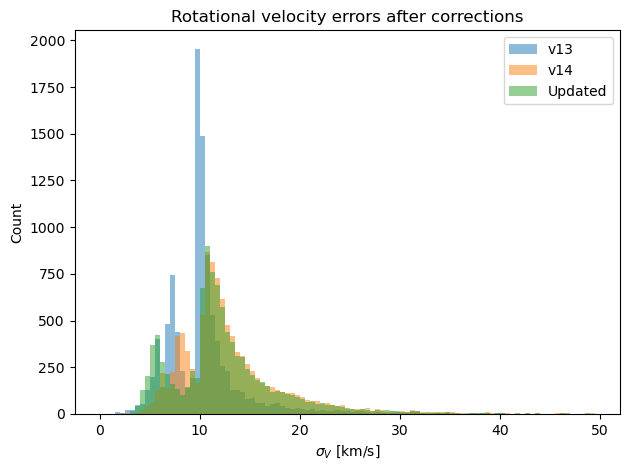

In [61]:
plt.figure(tight_layout=True)

plt.hist(v13['V_0p4R26_ERR'], bins=np.arange(0,50,0.5), alpha=0.5, label='v13')
plt.hist(v14['V_0p4R26_ERR'], bins=np.arange(0,50,0.5), alpha=0.5, label='v14')
plt.hist(SGA_TF_iron_photsys['V_0p4R26_ERR'], alpha=0.5, bins=np.arange(0,50,0.5), label='Updated')

plt.title('Rotational velocity errors after corrections')
plt.xlabel(r'$\sigma_V$ [km/s]')
plt.ylabel('Count')
plt.legend();

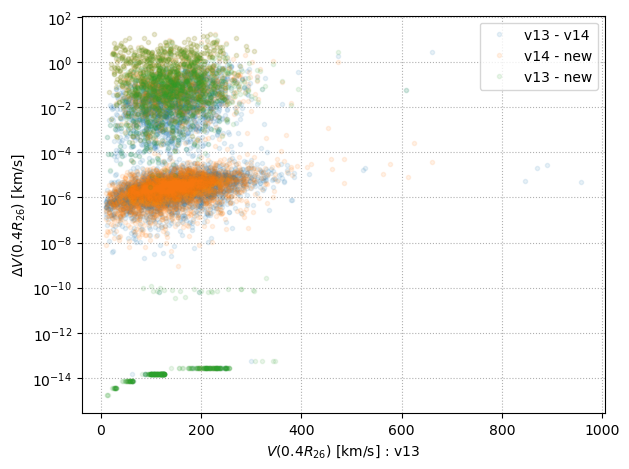

In [75]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.semilogy(v13_v14_new['V_0p4R26_v13'], v13_v14_new['V_0p4R26_v13'] - v13_v14_new['V_0p4R26_v14'], '.', alpha=0.1, label='v13 - v14')
plt.semilogy(v13_v14_new['V_0p4R26_v13'], v13_v14_new['V_0p4R26_v14'] - v13_v14_new['V_0p4R26'], '.', alpha=0.1, label='v14 - new')
plt.semilogy(v13_v14_new['V_0p4R26_v13'], v13_v14_new['V_0p4R26_v13'] - v13_v14_new['V_0p4R26'], '.', alpha=0.1, label='v13 - new')

plt.legend()

plt.xlabel('$V(0.4R_{26})$ [km/s] : v13')
plt.ylabel('$\Delta V(0.4R_{26})$ [km/s]');

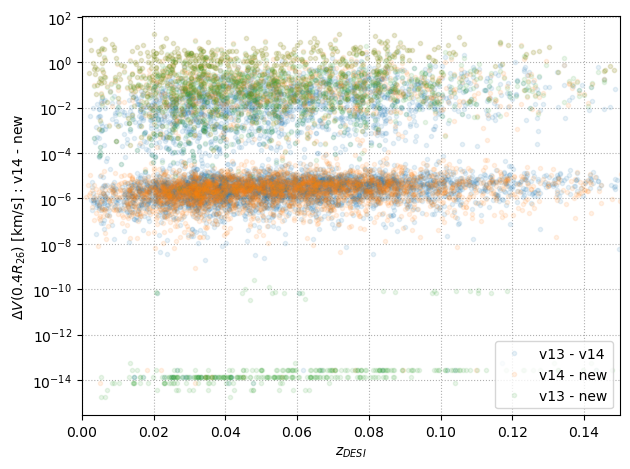

In [76]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.semilogy(v13_v14_new['Z_DESI'], v13_v14_new['V_0p4R26_v13'] - v13_v14_new['V_0p4R26_v14'], '.', alpha=0.1, label='v13 - v14')
plt.semilogy(v13_v14_new['Z_DESI'], v13_v14_new['V_0p4R26_v14'] - v13_v14_new['V_0p4R26'], '.', alpha=0.1, label='v14 - new')
plt.semilogy(v13_v14_new['Z_DESI'], v13_v14_new['V_0p4R26_v13'] - v13_v14_new['V_0p4R26'], '.', alpha=0.1, label='v13 - new')

plt.legend()

plt.xlim(0,0.15)

plt.xlabel('$z_{DESI}$')
plt.ylabel('$\Delta V(0.4R_{26})$ [km/s] : v14 - new');

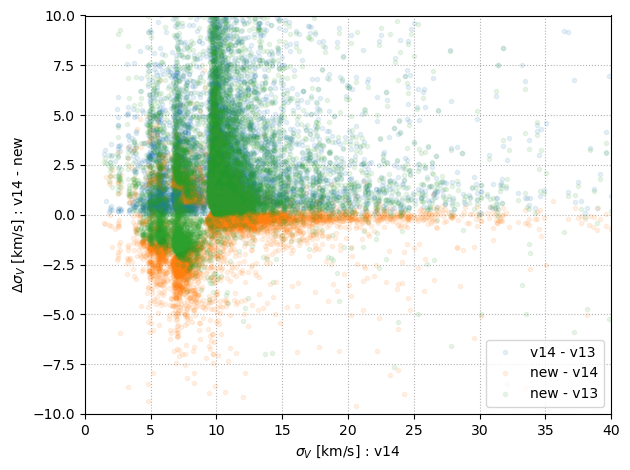

In [77]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.plot(v13_v14_new['V_0p4R26_ERR_v13'], v13_v14_new['V_0p4R26_ERR_v14'] - v13_v14_new['V_0p4R26_ERR_v13'], '.', alpha=0.1, label='v14 - v13')
plt.plot(v13_v14_new['V_0p4R26_ERR_v13'], v13_v14_new['V_0p4R26_ERR'] - v13_v14_new['V_0p4R26_ERR_v14'], '.', alpha=0.1, label='new - v14')
plt.plot(v13_v14_new['V_0p4R26_ERR_v13'], v13_v14_new['V_0p4R26_ERR'] - v13_v14_new['V_0p4R26_ERR_v13'], '.', alpha=0.1, label='new - v13')

plt.legend()

plt.xlim(0, 40)
plt.ylim(-10, 10)

plt.xlabel('$\sigma_V$ [km/s] : v14')
plt.ylabel('$\Delta \sigma_V$ [km/s] : v14 - new');

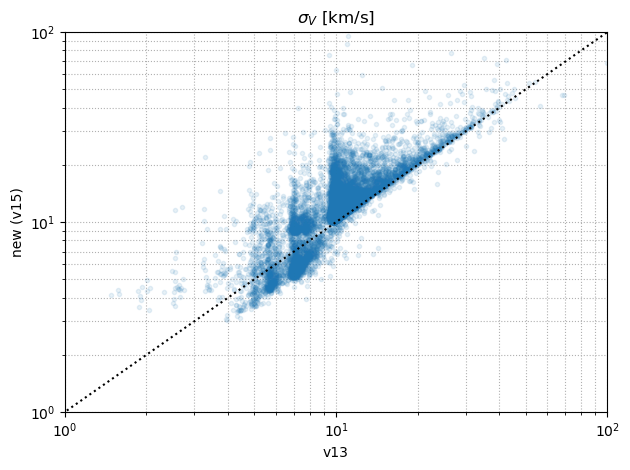

In [102]:
plt.figure(tight_layout=True)

plt.grid(ls=':', which='both')

# plt.loglog(v13_v14_new['V_0p4R26_ERR_v13'], v13_v14_new['V_0p4R26_ERR_v14'], '.', alpha=0.1, label='x=v13, y=v14')
# plt.loglog(v13_v14_new['V_0p4R26_ERR_v14'], v13_v14_new['V_0p4R26_ERR'], '.', alpha=0.1, label='x=v14, y=new')
plt.loglog(v13_v14_new['V_0p4R26_ERR_v13'], v13_v14_new['V_0p4R26_ERR'], '.', alpha=0.1, label='x=v13, y=new')

plt.loglog([0,100], [0,100], 'k:')

# plt.legend()

plt.xlim(1,100)
plt.ylim(1,100)

plt.title('$\sigma_V$ [km/s]');
plt.xlabel('v13')
plt.ylabel('new (v15)');

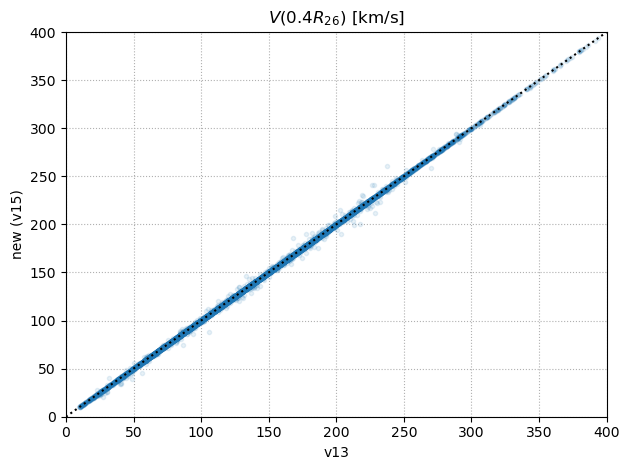

In [106]:
plt.figure(tight_layout=True)

plt.grid(ls=':', which='both')

# plt.plot(v13_v14_new['V_0p4R26_v13'], v13_v14_new['V_0p4R26_v14'], '.', alpha=0.1, label='x=v13, y=v14')
# plt.plot(v13_v14_new['V_0p4R26_v14'], v13_v14_new['V_0p4R26'], '.', alpha=0.1, label='x=v14, y=new')
plt.plot(v13_v14_new['V_0p4R26_v13'], v13_v14_new['V_0p4R26'], '.', alpha=0.1, label='x=v13, y=new')

plt.plot([0,1000], [0,1000], 'k:')

# plt.legend()

plt.xlim(0,400)
plt.ylim(0,400)

plt.title('$V(0.4R_{26})$ [km/s]');
plt.xlabel('v13')
plt.ylabel('new (v15)');

# Compare with Alex's calculations

In [46]:
Alex = Table.read('SGA-2020_iron_Vrot_VI_corr_alex.fits')

Alex[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,center_and_axis,Z_DESI,ZERR_DESI,Z_C,Z_V,Z_V_ERR,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bool,float64,float64,float64,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,True,0.0809898865247745,2.552104184200612e-

In [81]:
# Join two tables together for comparisons
v13_v14_new_alex = join(v13_v14_new, 
                        Alex['SGA_ID', 'V_0p4R26', 'V_0p4R26_ERR'], 
                        keys='SGA_ID', 
                        table_names=['new', 'alex'])
v13_v14_new_alex

SGA_ID,Z_DESI,ZERR_DESI,V_0p4R26_new,V_0p4R26_ERR_new,V_0p4R26_v13,V_0p4R26_ERR_v13,V_0p4R26_v14,V_0p4R26_ERR_v14,V_0p4R26_alex,V_0p4R26_ERR_alex
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
38.0,0.0809898865247745,2.5975581332155182e-05,122.3223893029039,11.199286747864958,122.3223893029039,9.671537005812278,122.32238811543634,11.198383235519104,122.91294713675433,10.211370646807413
55.0,0.0440016373089485,2.6681212474333698e-05,81.31490064859103,6.544236935177211,81.3789130370326,7.725161740109695,81.45040086564465,8.96603076461634,85.41601731347835,6.51401456926578
117.0,0.0900398334789895,3.812466038925675e-05,180.6557315191658,13.703729472844426,180.6557315191658,12.555107762887319,180.65572517100514,13.988234062982217,185.71402830737736,12.81767349965874
223.0,0.0340259256442166,2.5381363229864585e-05,70.1020042633194,12.017192541858238,70.1020042633194,10.55954809258847,70.10200300303902,12.067030815491611,65.2920500458494,10.784402856626786
581.0,0.0433192742619632,2.7255472554136225e-05,133.77852107143553,10.96714989369019,133.77852107143553,10.574319515162813,133.77852340476574,11.02226922144289,138.8128509908654,10.840600243081033
669.0,0.0835905601112797,3.069976113296903e-05,292.50047126155704,16.408317403057577,292.50047126155704,10.925611527814912,292.50050130867885,16.892596796509988,317.17016992510116,16.525700101326223
731.0,0.077142277402868,2.716114821578034e-05,81.61279266055006,11.775309080523868,81.61279266055006,10.202851574557778,81.61279338923849,11.94046569258273,80.09103178953066,10.675024283324056
1135.0,0.0788890438854555,2.6771570734107397e-05,230.24449569210842,4.9258052232276075,218.6644091796399,5.611390610391208,218.68085076744163,7.017316819104426,253.3092993566866,4.948190297590632
1158.0,0.046436126958724,2.4527018841467138e-05,177.66056756020413,10.807692195383957,177.66056756020413,9.72984498796923,177.6605660298364,10.913290676982584,173.27311765922866,10.055893415144338


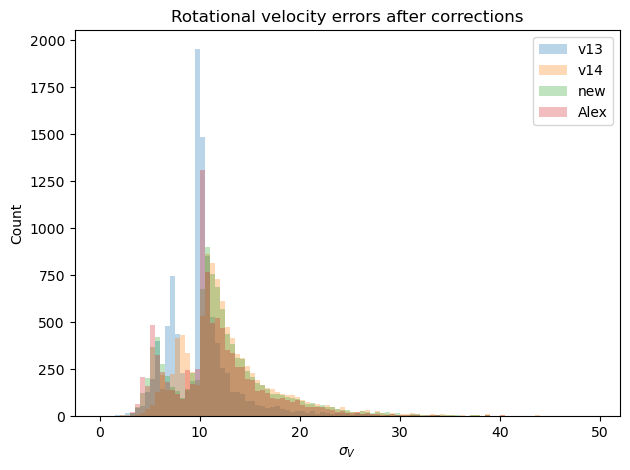

In [93]:
plt.figure(tight_layout=True)

plt.hist(v13['V_0p4R26_ERR'], bins=np.arange(0,50,0.5), alpha=0.3, label='v13')
plt.hist(v14['V_0p4R26_ERR'], bins=np.arange(0,50,0.5), alpha=0.3, label='v14')
plt.hist(SGA_TF_iron_photsys['V_0p4R26_ERR'], alpha=0.3, bins=np.arange(0,50,0.5), label='new')
plt.hist(Alex['V_0p4R26_ERR'], alpha=0.3, bins=np.arange(0,50,0.5), label='Alex')

plt.title('Rotational velocity errors after corrections')
plt.xlabel(r'$\sigma_V$')
plt.ylabel('Count')
plt.legend();

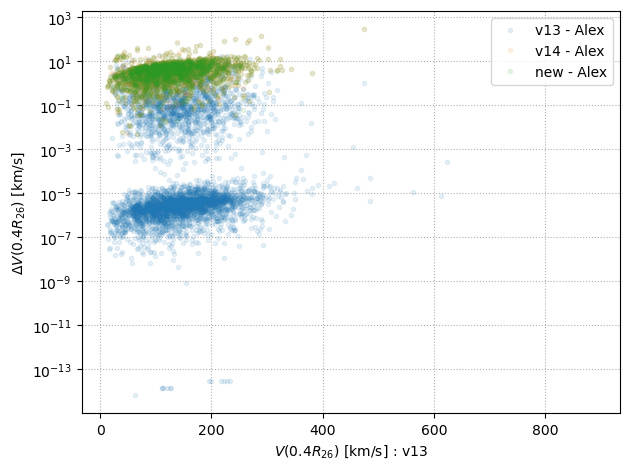

In [94]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.semilogy(v13_v14_new_alex['V_0p4R26_v13'], v13_v14_new_alex['V_0p4R26_v14'] - v13_v14_new_alex['V_0p4R26_new'], '.', alpha=0.1, label='v13 - Alex')
plt.semilogy(v13_v14_new_alex['V_0p4R26_v13'], v13_v14_new_alex['V_0p4R26_v14'] - v13_v14_new_alex['V_0p4R26_alex'], '.', alpha=0.1, label='v14 - Alex')
plt.semilogy(v13_v14_new_alex['V_0p4R26_v13'], v13_v14_new_alex['V_0p4R26_new'] - v13_v14_new_alex['V_0p4R26_alex'], '.', alpha=0.1, label='new - Alex')

plt.legend()

plt.xlabel('$V(0.4R_{26})$ [km/s] : v13')
plt.ylabel('$\Delta V(0.4R_{26})$ [km/s]');

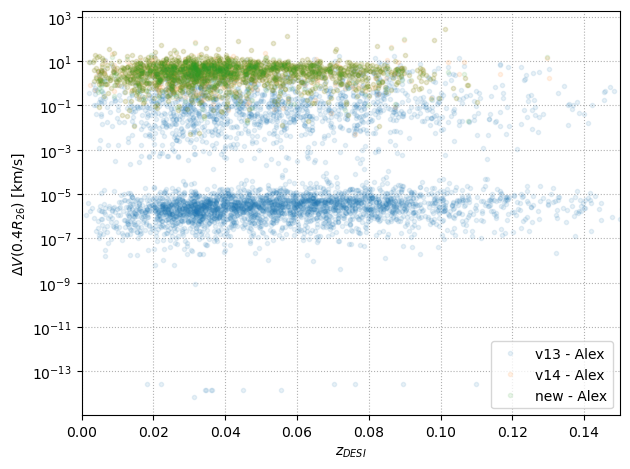

In [95]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.semilogy(v13_v14_new_alex['Z_DESI'], v13_v14_new_alex['V_0p4R26_v14'] - v13_v14_new_alex['V_0p4R26_new'], '.', alpha=0.1, label='v13 - Alex')
plt.semilogy(v13_v14_new_alex['Z_DESI'], v13_v14_new_alex['V_0p4R26_v14'] - v13_v14_new_alex['V_0p4R26_alex'], '.', alpha=0.1, label='v14 - Alex')
plt.semilogy(v13_v14_new_alex['Z_DESI'], v13_v14_new_alex['V_0p4R26_new'] - v13_v14_new_alex['V_0p4R26_alex'], '.', alpha=0.1, label='new - Alex')

plt.legend()

plt.xlim(0,0.15)

plt.xlabel('$z_{DESI}$')
plt.ylabel('$\Delta V(0.4R_{26})$ [km/s]');

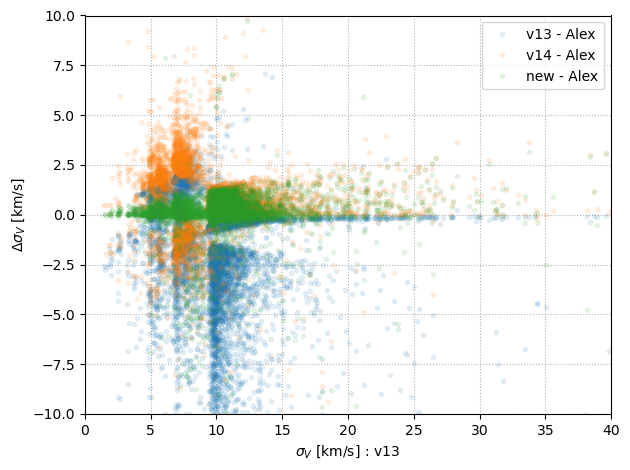

In [99]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.plot(v13_v14_new_alex['V_0p4R26_ERR_v13'], v13_v14_new_alex['V_0p4R26_ERR_v13'] - v13_v14_new_alex['V_0p4R26_ERR_alex'], '.', alpha=0.1, label='v13 - Alex')
plt.plot(v13_v14_new_alex['V_0p4R26_ERR_v13'], v13_v14_new_alex['V_0p4R26_ERR_v14'] - v13_v14_new_alex['V_0p4R26_ERR_alex'], '.', alpha=0.1, label='v14 - Alex')
plt.plot(v13_v14_new_alex['V_0p4R26_ERR_v13'], v13_v14_new_alex['V_0p4R26_ERR_new'] - v13_v14_new_alex['V_0p4R26_ERR_alex'], '.', alpha=0.1, label='new - Alex')

plt.legend()

plt.xlim(0, 40)
plt.ylim(-10, 10)

plt.xlabel('$\sigma_V$ [km/s] : v13')
plt.ylabel('$\Delta \sigma_V$ [km/s]');

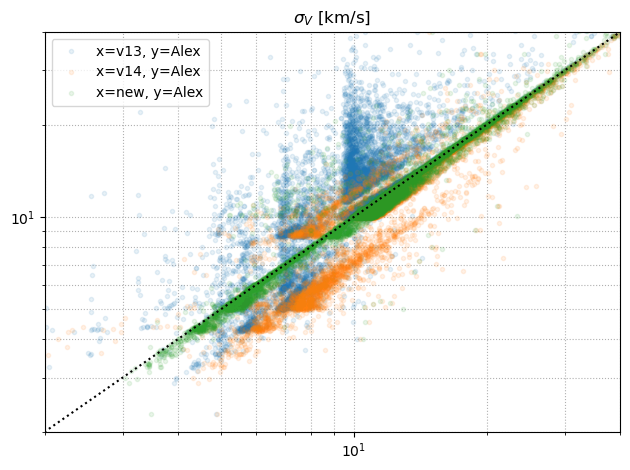

In [89]:
plt.figure(tight_layout=True)

plt.grid(ls=':', which='both')

plt.loglog(v13_v14_new_alex['V_0p4R26_ERR_v13'], v13_v14_new_alex['V_0p4R26_ERR_alex'], '.', alpha=0.1, label='x=v13, y=Alex')
plt.loglog(v13_v14_new_alex['V_0p4R26_ERR_v14'], v13_v14_new_alex['V_0p4R26_ERR_alex'], '.', alpha=0.1, label='x=v14, y=Alex')
plt.loglog(v13_v14_new_alex['V_0p4R26_ERR_new'], v13_v14_new_alex['V_0p4R26_ERR_alex'], '.', alpha=0.1, label='x=new, y=Alex')

plt.loglog([0,100], [0,100], 'k:')

plt.legend()

plt.xlim(2,40)
plt.ylim(2,40)

plt.title('$\sigma_V$ [km/s]');

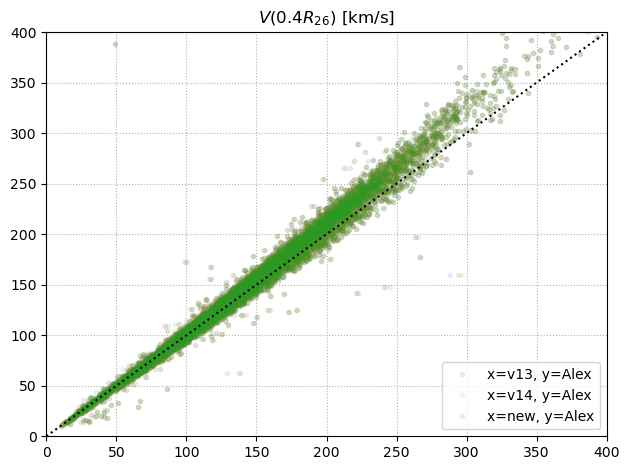

In [91]:
plt.figure(tight_layout=True)

plt.grid(ls=':', which='both')

plt.plot(v13_v14_new_alex['V_0p4R26_v13'], v13_v14_new_alex['V_0p4R26_alex'], '.', alpha=0.1, label='x=v13, y=Alex')
plt.plot(v13_v14_new_alex['V_0p4R26_v14'], v13_v14_new_alex['V_0p4R26_alex'], '.', alpha=0.1, label='x=v14, y=Alex')
plt.plot(v13_v14_new_alex['V_0p4R26_new'], v13_v14_new_alex['V_0p4R26_alex'], '.', alpha=0.1, label='x=new, y=Alex')

plt.plot([0,1000], [0,1000], 'k:')

plt.legend()

plt.xlim(0,400)
plt.ylim(0,400)

plt.title('$V(0.4R_{26})$ [km/s]');